In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from fbprophet import Prophet
import pmdarima as pm


Importing plotly failed. Interactive plots will not work.


Pulling in Data from KU_Pandas_for_database for a trial run of the Machine Learning Model

In [2]:
import yfinance as yf
df_nike = yf.download('NKE', start='2019-01-01', end='2022-01-01', progress=False)

df_nike.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,72.790001,74.639999,72.190002,74.059998,71.708588,6762700
2019-01-03,73.250000,73.320000,71.209999,72.750000,70.440208,8007400
2019-01-04,73.449997,75.120003,73.120003,74.650002,72.279861,7844200
2019-01-07,74.739998,76.360001,74.300003,75.720001,73.315887,8184800
2019-01-08,76.830002,77.400002,76.199997,76.730003,74.293839,8809000


In [3]:
df_sp = yf.download('^GSPC', start='2019-01-01', end='2022-01-01', progress=False)

Plotting Closing Price to visualize 

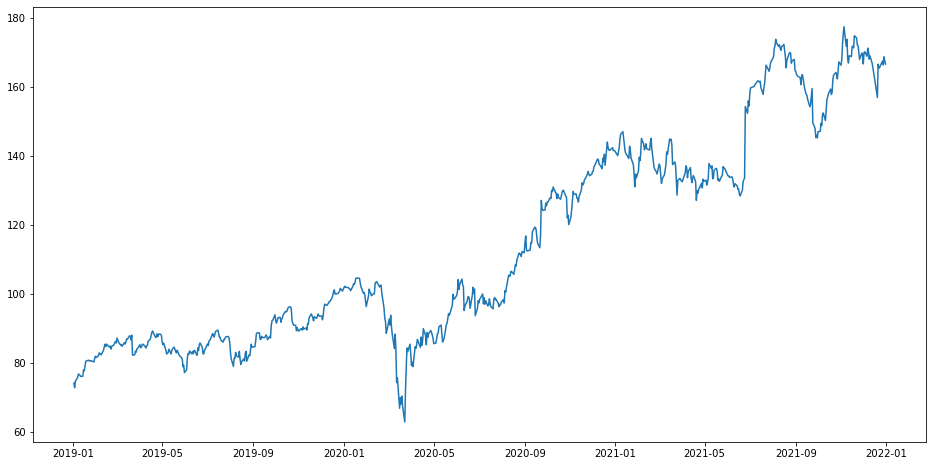

In [4]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df_nike['Close'], label='Close Price History')

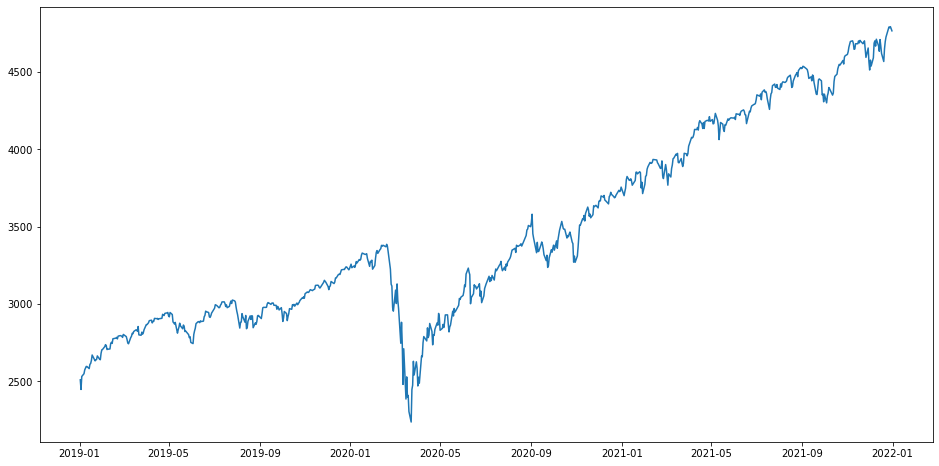

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df_sp['Close'], label='Close Price History')

Looking at the Distribution of the Dataset

<AxesSubplot:ylabel='Density'>

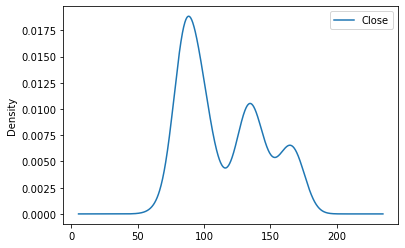

In [6]:
df_nike_close = df_nike[['Close']]
df_nike_close.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

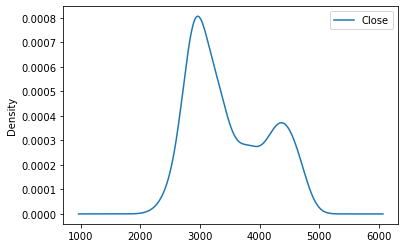

In [7]:
df_sp_close = df_sp[['Close']]
df_sp_close.plot(kind='kde')

Splitting Data into Train and Test DataSet into 80% Training Data and 20% Testing Data

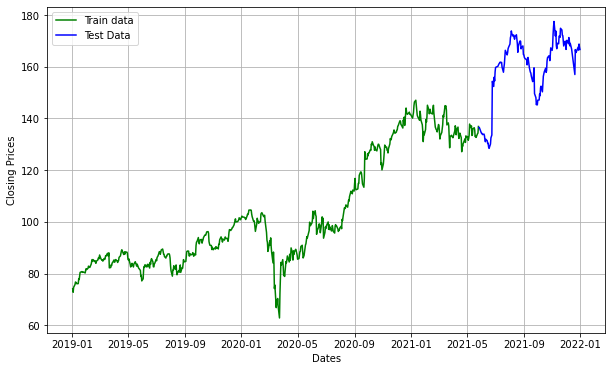

In [8]:
nike_train_data= df_nike_close.iloc[:int(df_nike_close.shape[0]*0.8)]
nike_test_data = df_nike_close.iloc[int(df_nike_close.shape[0]*0.80):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nike_train_data, 'Green', label='Train data')
plt.plot(nike_test_data, 'blue',  label='Test Data')
plt.legend()

This Machine Learning Model will run a linear regression, ARIMA model, and a Facebook Prophet model
- limitations of these models will be they do not take into account current world situations (like COVID impacts on economy)

Linear Regression Model

In [9]:
df_linear_nike = pd.merge(df_nike_close, df_sp_close, on='Date')
df_linear_nike = df_linear_nike.rename(columns={'Close_x': 'Nike Close', 'Close_y':'S&P Close'})

In [10]:
# for linear regression model we need an x_train value, and a y_train value
X_train, X_test, y_train, y_test = train_test_split(df_linear_nike[['Nike Close']], df_linear_nike[['S&P Close']], test_size=.2)

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = linear_regression_model.predict(X_test)

In [12]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [13]:
print('Mean Absolute Error:', mae)
print('Coefficient of Determination:', r2)
print('Mean Squared Error:', mse)

Mean Absolute Error: 118.50963771194768
Coefficient of Determination: 0.944999934335123
Mean Squared Error: 24242.23505223605


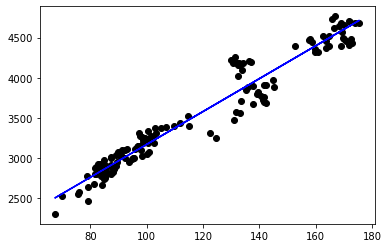

In [14]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue')
plt.show()

Arima Model

In [15]:
# ARIMA Model
arima_model = pm.auto_arima(nike_train_data, d=1, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=6, max_order=None , trace=True)

arima_model.fit(nike_train_data)


Performing stepwise search to minimize aic


/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2507.731, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2502.011, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2503.638, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2503.662, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2501.793, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2505.179, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.753 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
arima_y_pred = nike_test_data.copy()

# Forecasting the Data
prediction_arima = arima_model.predict(len(nike_test_data))
arima_y_pred["ARIMA Model Prediction"]=prediction_arima

In [17]:
r2_arima = r2_score(arima_y_pred["Close"], arima_y_pred["ARIMA Model Prediction"])
mae_arima = mean_absolute_error(arima_y_pred["Close"], arima_y_pred["ARIMA Model Prediction"])
mse_arima = mean_squared_error(arima_y_pred['Close'], arima_y_pred["ARIMA Model Prediction"])

print('Mean Absolute Error for ARIMA Model:', mae_arima)
print('Coefficient of Determination for ARIMA Model:', r2_arima)
print('Mean Squared Error for ARIMA Model:', mse_arima)

Mean Absolute Error for ARIMA Model: 23.85454037314967
Coefficient of Determination for ARIMA Model: -3.2805884703045516
Mean Squared Error for ARIMA Model: 672.5612670906672


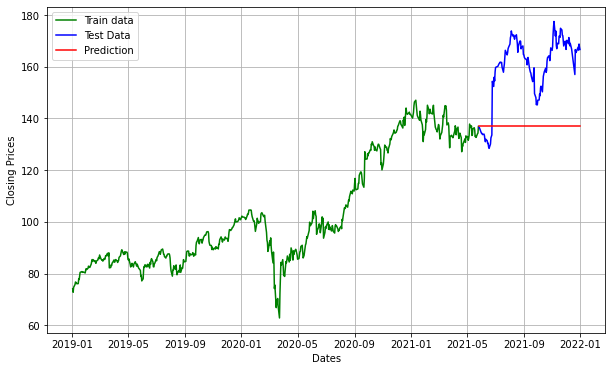

In [18]:
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nike_train_data, 'Green', label='Train data')
plt.plot(nike_test_data, 'blue',  label='Test Data')
plt.plot(arima_y_pred["ARIMA Model Prediction"], 'Red', label='Prediction')
plt.legend()


Facebook Prophet Model with Plot of Actual vs Predictions

In [19]:
# Facebook Prophet Model
prophet_data = df_nike_close.copy()
prophet_data = prophet_data.reset_index()

#preparing data
prophet_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
prophet_train = prophet_data[:int(prophet_data.shape[0]*0.80)]
prophet_test = prophet_data[int(prophet_data.shape[0]*0.80):]

#fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

#predictions
close_prices = prophet_model.make_future_dataframe(periods=len(prophet_test))
forecast = prophet_model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.58753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1853.38     0.0213974       503.648           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1882.91     0.0019271         357.7           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257        1890.1   0.000117586       218.728   4.142e-07       0.001      346  LS failed, Hessian reset 
     299       1893.15   0.000682269       285.384           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1902.19   0.000927855       128.211      0.3352      0.3352      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     486       1905.12   8.16871e-05    

In [20]:
forecast = forecast.set_index('ds')
forecast = forecast.rename(columns={'yhat':'Prediction'})

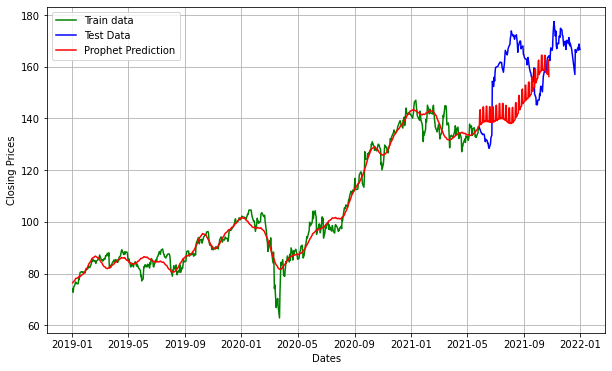

In [21]:
# Facebook Prophet Models
#plot
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(nike_train_data, 'Green', label='Train data')
plt.plot(nike_test_data, 'blue',  label='Test Data')
plt.plot(forecast['Prediction'], 'Red', label='Prophet Prediction')
plt.legend()


#Will need to update model so it predicts full test data


In [22]:
# Get Statistics for Prophet Predictions